# ISIC 2024 Skin Cancer Detection with 3D-TBP | Kaggle


##0. Google Colab Setup 🧰

In [ ]:
# Mount your Google Drive files Following code make mount your google drive
# By using Google Drive, you ensure that your data is persistently stored and accessible across different Colab sessions.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Upload the kaggle.json file
from google.colab import files
files.upload()

{}

In [ ]:
# Install kaggle API client
! pip install -q kaggle
#  kaggle API client expects the file to be in ~/.kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c isic-2024-challenge

 99% 1.98G/2.00G [00:25<00:00, 145MB/s]
100% 2.00G/2.00G [00:25<00:00, 85.5MB/s]


In [ ]:
# ! cp -r /content/isic-2024-challenge.zip /content/gdrive/MyDrive/

In [ ]:
# ! unzip gdrive/MyDrive/ISIC-2024-Challenge/isic-2024-challenge.zip -d gdrive/MyDrive/ISIC-2024-Challenge/

Streaming output truncated to the last 5000 lines.
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874656.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874659.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874663.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874742.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874751.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874803.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874805.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874832.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874878.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874897.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874925.jpg  
  inflating: g

In [ ]:
# ! unzip gdrive/MyDrive/ISIC-2024-Challenge/isic-2024-challenge.zip train-metadata.csv -d gdrive/MyDrive/ISIC-2024-Challenge/

Archive:  gdrive/MyDrive/ISIC-2024-Challenge/isic-2024-challenge.zip
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-metadata.csv  


## 1. Introduction ⏯

1.1 What is skin cancer? Statistics & Facts (taken from Skin Cancer dot org)

- [The world's most common skin cancer is a relentless disease that strikes one in five people by age 70. The good news is that most cases are curable if they are diagnosed and treated early enough. But in order to stop skin cancer, we have to spot it in time.](https://www.skincancer.org/early-detection/)
- Dermascopy-based AI algorithms have shown to benefit clinicians in diagnosing various skin cancers (i.e., melanoma, basal cell, and squamous cell carcinoma).
- **Skin cancer is the cancer you can see.** Skin cancers form on the outside of the body and usually visible. That's why skin exams, both at home and with a dermatologist, are especially vital. However, many populations lack access to specialized care.
- **Early detection saves lives.** Dermascopy-based AI algorithms have shown to benefit clinicians in diagnosing various skin cancers (i.e., melanoma, basal cell, and squamous cell carcinoma). Triaging applications have a significant potential to benefit underserved populations and improve healthcare outcomes.
- **Algorithms must be adept to evaluating lower quality images.** Dermatoscope images reveal morphologic features not visible to the naked eye, but these images are typically only captured in dermatology clinics.


1.2 Competition: https://www.kaggle.com/competitions/isic-2024-challenge

This competition challenges you to develop AI algorithms that differentiate histologically-confirmed malignant skin lesions from benign lesions on a patient. Your work will help to improve early diagnosis and disease prognosis by extending the benefits of automated skin cancer detection to a broader population and settings.

*Note: Extending this project to an app/website with a natural language interface would be great fun.*

## 2. Libraries 📖


In [ ]:
# Regular Imports
import pandas as pd
import numpy as np
import random
import h5py
import os
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
# Torch version
print(torch.__version__)

2.3.1+cu121


In [ ]:
# Device (Google Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Hardware accelator: {device}")

Hardware accelator: cpu


## 3. Dataset 📨 🧹
Among the most employed initial diagnostic methods is the ABCDE criteria [3,6,7], which are described in Table 1. Nevertheless, while this simple, noninvasive, and expertise-based observational approach often leads to an accurate diagnosis of between **60** and **90% of malignant tumors** [3], there are scenarios where the certainty of cancer’s presence can only be ascertained through a biopsy.

Citation: https://www.mdpi.com/2075-4418/14/4/454

**Table 1**
--
| Criteria | Indicates | Description |
| --- | --- | --- |
| A | Asymmetry | The majority of illustrated melanomas exhibit an imbalance in their features |
| B | Border | The borders of melanomas are usually uneven and may have irregular or scalloped edges |
| C | Color | The presence of multiple colors within a melanoma is a warning sign |
| D | Diameter | Melanomas tend to be larger, approximately the size of an eraser or around 6 mm in diameter or larger |
| E | Evolution | This considers any alteration in the shape, size, color, or elevation of a skin spot as a warning sign of melanoma |

In [ ]:
# Metadata Path
train_metadata_path = "gdrive/MyDrive/ISIC-2024-Challenge/train-metadata.csv"
train_img_path = "gdrive/MyDrive/ISIC-2024-Challenge/train-image.hdf5"

test_metadata_path = "gdrive/MyDrive/ISIC-2024-Challenge/test-metadata.csv"
test_img_path = "gdrive/MyDrive/ISIC-2024-Challenge/test-image.hdf5"

In [ ]:
train_metadata = pd.read_csv(train_metadata_path, dtype={'iddx_5': str, 'mel_mitotic_index': str})
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [ ]:
test_metadata = pd.read_csv(test_metadata_path, dtype={'iddx_5': str, 'mel_mitotic_index': str})
test_metadata

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


We have severe inbalance in our training test. We will consider oversampling the malignant group or undersampling the benign group.

In [ ]:
print(f"Benign class: {len(train_metadata.loc[train_metadata['target']==1])} patients")
print(f"Malignant class: {len(train_metadata.loc[train_metadata['target']==0])} patients")

Benign class: 393 patients
Malignant class: 400666 patients


We also have many missing values (that is often the case with many medical data).

In [ ]:
# train_metadata.info()

<Axes: >

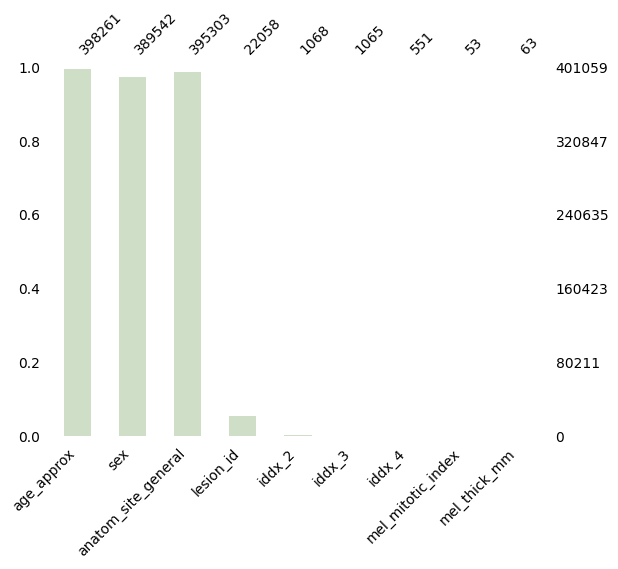

In [ ]:
f, ax1 = plt.subplots(1, 1)
msno.bar(train_metadata[['age_approx', 'sex', 'anatom_site_general', 'lesion_id', 'iddx_2',
                         'iddx_3', 'iddx_4','mel_mitotic_index', 'mel_thick_mm']],
         ax = ax1, color=(207/255, 196/225, 175/225), fontsize=10)


**Train**:
1. sex:  11517 missing values (2.9% of total data)
2. anatom_site_general: 5756 missing values (1.4% of total data)
3. age_approx: 2798 missing values (0.7% of total data)


- We will address the missingness in a cascade fashion and handle those missing values as they affect the imputation of the other values
- The remaining missing columns will be require addditional thought and remember: **Imputation is a means to a goal, not the goal itself**.
- Consider whether imputation is actually appropriate for answering whether a skin lesion is cancerous.

Train: SEX variable
> Missing values for the feature sex account for nearly 3% of the total data and 10 pts of 11,517 are malignant.

In [ ]:
# Data
nan_sex = train_metadata[train_metadata['sex'].isna() == True]
is_sex = train_metadata[train_metadata['sex'].isna() == False]

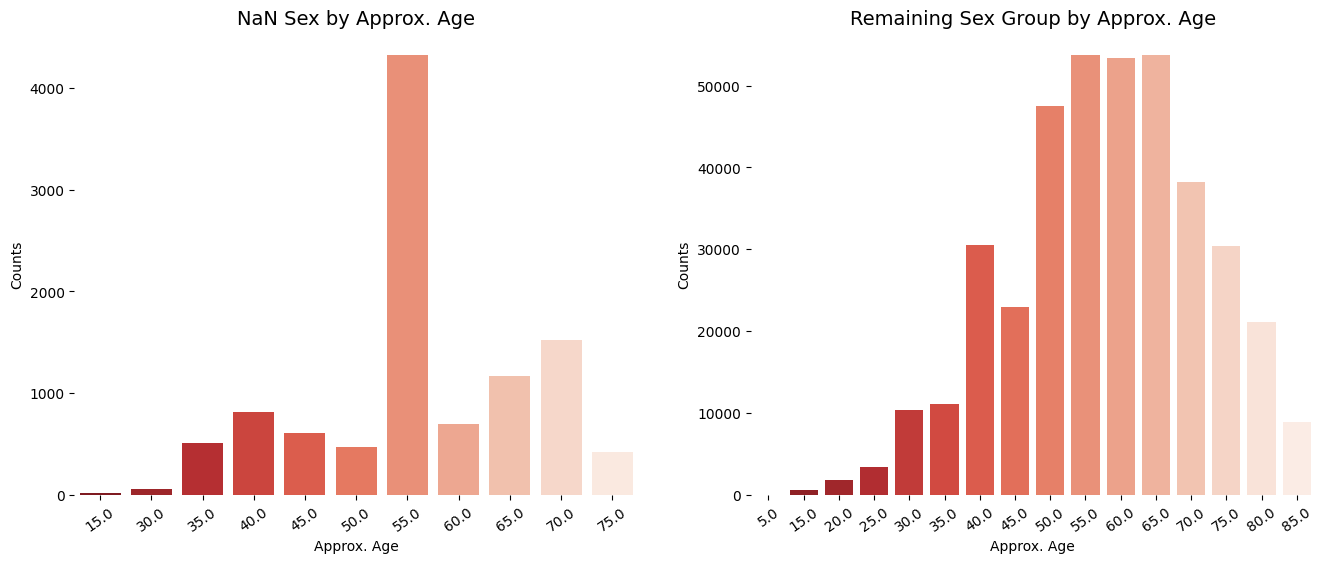

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16,6))

a = sns.countplot(data=nan_sex, x ='age_approx', ax=ax1, palette="Reds_r")

b = sns.countplot(data=is_sex, x ='age_approx', ax=ax2, palette="Reds_r")

ax1.set_title("NaN Sex by Approx. Age", fontsize=14)
ax2.set_title("Remaining Sex Group by Approx. Age", fontsize=14)

ax1.set(xlabel="Approx. Age", ylabel="Counts")
ax2.set(xlabel="Approx. Age", ylabel="Counts")

ax1.tick_params(axis='x', labelrotation = 35)
ax2.tick_params(axis='x', labelrotation = 35)
sns.despine(left=True, bottom=True);

plt.show()

In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(train_metadata['age_approx'], train_metadata['sex'].isna())
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [ ]:
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies:\n{expected_df}")

Chi-Square Statistic: 7798.53407905641
p-value: 0.0
Degrees of Freedom: 15
Expected Frequencies:
sex                False        True 
age_approx                           
5.0             0.973369     0.026631
15.0          626.849779    17.150221
20.0         1695.609186    46.390814
25.0         3341.576542    91.423458
30.0        10123.039916   276.960084
35.0        11235.600938   307.399062
40.0        30463.536563   833.463437
45.0        22952.046271   627.953729
50.0        46647.746628  1276.253372
55.0        56575.139331  1547.860669
60.0        52668.035271  1440.964729
65.0        53482.745310  1463.254690
70.0        38715.760833  1059.239167
75.0        29980.745428   820.254572
80.0        20534.197122   561.802878
85.0         8611.397513   235.602487


> The Chi2 test done above suggests there might be an association between age 55 and the missing data for the missing 'sex' variable.

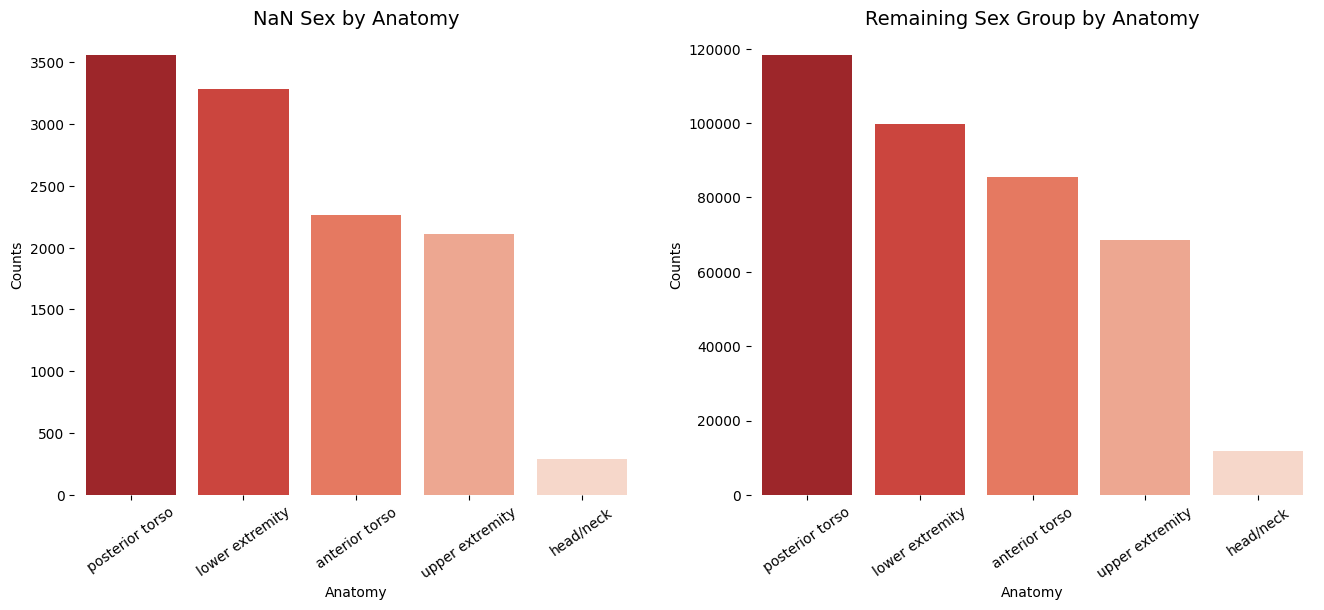

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16,6))

a = sns.countplot(data=nan_sex, x ='anatom_site_general', ax=ax1, palette="Reds_r",
                  order = nan_sex['anatom_site_general'].value_counts().index)

b = sns.countplot(data=is_sex, x ='anatom_site_general', ax=ax2, palette="Reds_r",
                  order = is_sex['anatom_site_general'].value_counts().index)

ax1.set_title("NaN Sex by Anatomy", fontsize=14)
ax2.set_title("Remaining Sex Group by Anatomy", fontsize=14)

ax1.set(xlabel="Anatomy", ylabel="Counts")
ax2.set(xlabel="Anatomy", ylabel="Counts")

ax1.tick_params(axis='x', labelrotation = 35)
ax2.tick_params(axis='x', labelrotation = 35)
sns.despine(left=True, bottom=True);

plt.show()

In [ ]:
# The analysis above suggests the distribution remains the same and is not affected by the missing age values.
from sklearn.impute import SimpleImputer

# Seperate the data
age55 = train_metadata[train_metadata['age_approx'] == 55 ].copy()
n_age55 = train_metadata[train_metadata['age_approx'] != 55].copy()

age55_sex_imp = SimpleImputer(strategy='most_frequent')
age55[['sex']] = age55_sex_imp.fit_transform(age55[['sex']])

n_age55_sex_imp = SimpleImputer(strategy='most_frequent')
n_age55[['sex']] = age55_sex_imp.fit_transform(n_age55[['sex']])

In [ ]:
train_metadata.loc[train_metadata['age_approx'] == 55, 'sex'] = age55['sex'].values
train_metadata.loc[train_metadata['age_approx'] != 55, 'sex'] = n_age55['sex'].values

Train: ANATOMY variable

[SCCs commonly appear on sun-exposed areas of the body such as the face, ears, neck, lips, arms, and backs of the hands. ](https://www.cancer.org/cancer/types/basal-and-squamous-cell-skin-cancer/about/what-is-basal-and-squamous-cell.html) We have reason to believe there is a strong relationship between the general site of anatomy and the target variable, in addition to male workers often working outside compared to women.

In [ ]:
nan_anatomy = train_metadata[train_metadata['anatom_site_general'].isna() == True]
is_anatomy =  train_metadata[train_metadata['anatom_site_general'].isna() == False]

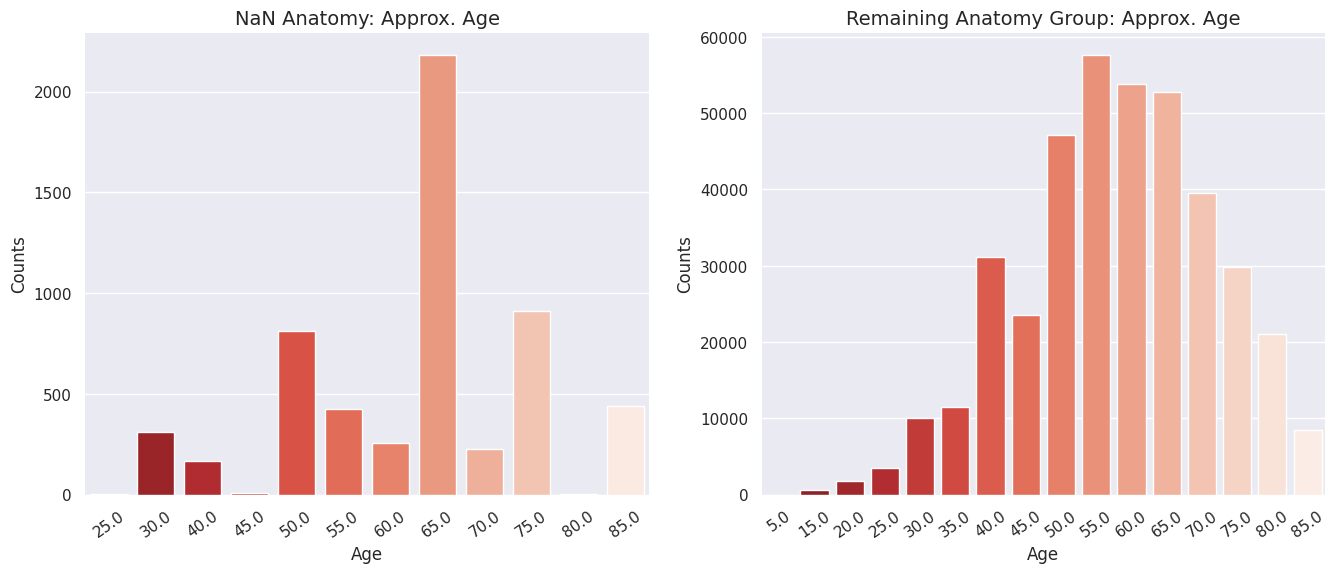

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16,6))

a = sns.countplot(data=nan_anatomy, x ='age_approx', ax=ax1, palette="Reds_r")

b = sns.countplot(data=is_anatomy, x ='age_approx', ax=ax2, palette="Reds_r")

ax1.set_title("NaN Anatomy: Approx. Age", fontsize=14)
ax2.set_title("Remaining Anatomy Group: Approx. Age", fontsize=14)

ax1.set(xlabel="Age", ylabel="Counts")
ax2.set(xlabel="Age", ylabel="Counts")

ax1.tick_params(axis='x', labelrotation = 35)
ax2.tick_params(axis='x', labelrotation = 35)
sns.despine(left=True, bottom=True);

plt.show()

In [ ]:
freq_val = train_metadata[train_metadata['age_approx'] == 65]

In [ ]:
len(nan_anatomy)

5756

Note: could find a better solution to impute the general anatomy site instead of using the 'posterior torso' for the remaining 6,000 patients.



In [ ]:
df_test = train_metadata[train_metadata['age_approx'] == 65]['anatom_site_general'].value_counts().reset_index()

In [ ]:
freq_anatomy = df_test.loc[0][0]
train_metadata['anatom_site_general'].fillna(freq_anatomy, inplace=True)

Train: APPROX AGE variable
> Nearly all missing values (2795 pts of 2798 pts) are benign and 3 pts are malignant. The top three anatomoy sites are the lower extremity, posterior torso, and anterior torso. Importantly, there is a notable bias towards women for missing values.

- We can consider using "Sex-Specific" or KNN imputation given the importance of age in predicting cancerous skin lesions. Would the extra features even help KNN anyway? Likely do sex-specific imputation.

In [ ]:
# Data
nan_age = train_metadata[train_metadata['age_approx'].isna() == True]
is_age = train_metadata[train_metadata['age_approx'].isna() == False]

In [ ]:
# potential bias toward women for missing age values
# nan_age.head(100)

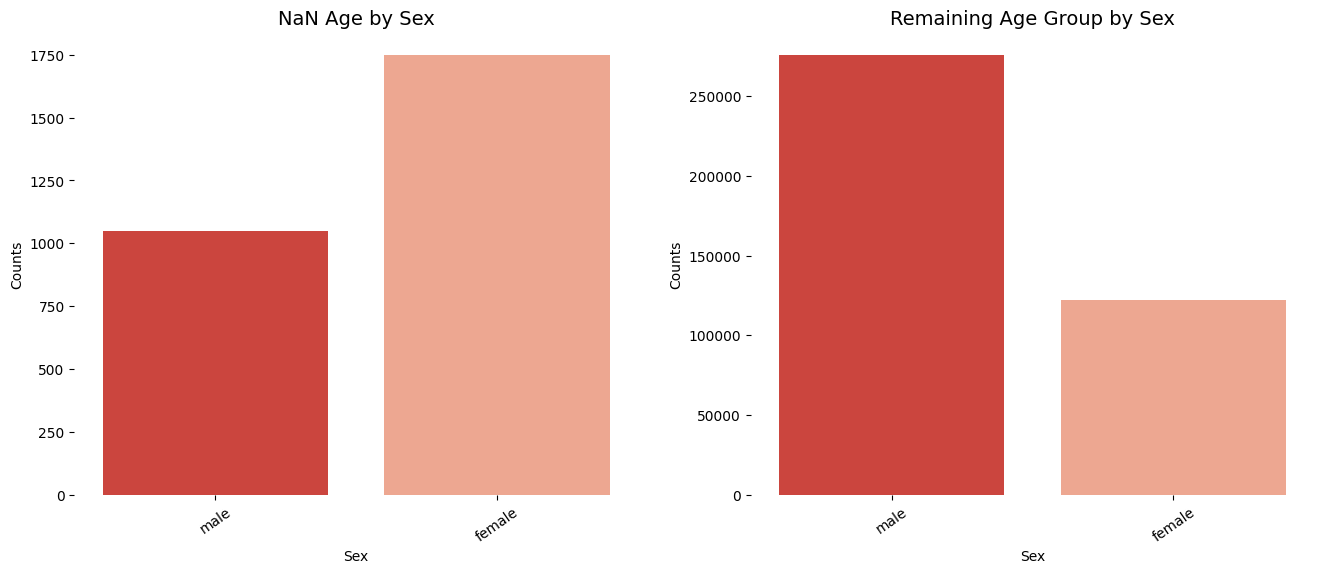

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16,6))

a = sns.countplot(data=nan_age, x ='sex', ax=ax1, palette="Reds_r")

b = sns.countplot(data=is_age, x ='sex', ax=ax2, palette="Reds_r")

ax1.set_title("NaN Age by Sex", fontsize=14)
ax2.set_title("Remaining Age Group by Sex", fontsize=14)

ax1.set(xlabel="Sex", ylabel="Counts")
ax2.set(xlabel="Sex", ylabel="Counts")

ax1.tick_params(axis='x', labelrotation = 35)
ax2.tick_params(axis='x', labelrotation = 35)
sns.despine(left=True, bottom=True);

plt.show()

**Potential Bias** 🛑

The pattern above might suggest a potential bias or sensitivity issue where women may be less likely to provide their age. This could be due to concerns about privacy or how the information might be used. This is often found in surveys and medical information. Missing data may disproportionately affect women in this dataset.

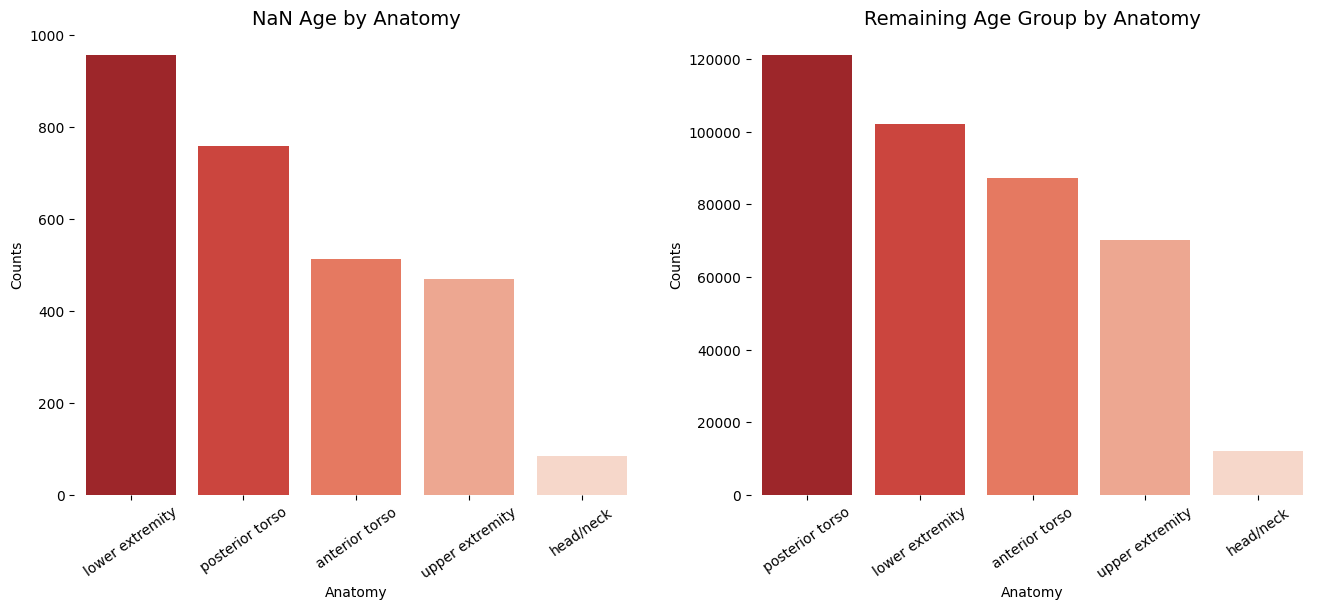

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16,6))

a = sns.countplot(data=nan_age, x ='anatom_site_general', ax=ax1, palette="Reds_r",
                  order = nan_age['anatom_site_general'].value_counts().index)

b = sns.countplot(data=is_age, x ='anatom_site_general', ax=ax2, palette="Reds_r",
                  order = is_age['anatom_site_general'].value_counts().index)

ax1.set_title("NaN Age by Anatomy", fontsize=14)
ax2.set_title("Remaining Age Group by Anatomy", fontsize=14)

ax1.set(xlabel="Anatomy", ylabel="Counts")
ax2.set(xlabel="Anatomy", ylabel="Counts")

ax1.tick_params(axis='x', labelrotation = 35)
ax2.tick_params(axis='x', labelrotation = 35)
sns.despine(left=True, bottom=True);

plt.show()

The plot above suggests that the missing data does not introduce significant biases related to anatomical regions, further suggesting that age biases are a social factor and may be handled fairly with sex-specific imputations.

In [ ]:
sex = ['male', 'female']

# Impute the data with sex-specific data
male = train_metadata[train_metadata['sex'] == 'male'].copy()
female = train_metadata[train_metadata['sex'] == 'female'].copy()

male_age_imp = SimpleImputer(strategy='median')
female_age_imp = SimpleImputer(strategy='median')

male[['age_approx']] = male_age_imp.fit_transform(male[['age_approx']])
female[['age_approx']] = female_age_imp.fit_transform(female[['age_approx']])

train_metadata.loc[train_metadata['sex'] == 'male', 'age_approx'] = male[['age_approx']].values
train_metadata.loc[train_metadata['sex'] == 'female', 'age_approx'] = female[['age_approx']].values

> Save the clean dataframe with imputations. Good practice!

In [ ]:
# train_metadata.to_csv('c_train_metadata.csv', index=False)

## 4. Exploratory Data Analysis

In [ ]:
print(train_metadata['sex'].value_counts()['male'])
print(train_metadata['sex'].value_counts()['female'])

KeyError: 'male'

In [ ]:
train_metadata.sex = train_metadata.sex.replace(["male","female"], [0,1]).astype("Int8")

# Mean Encoding https://www.geeksforgeeks.org/mean-encoding-machine-learning/
mean = train_metadata.groupby("anatom_site_general")["target"].mean()
train_metadata["anatom_site_mean"] = train_metadata["anatom_site_general"].map(mean)

In [ ]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,anatom_site_mean,age_range_under50
0,ISIC_0015670,0,IP_1235828,60.0,1,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,0.000709,False
1,ISIC_0015845,0,IP_8170065,60.0,1,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0.006475,False
2,ISIC_0015864,0,IP_6724798,60.0,1,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0.000807,False
3,ISIC_0015902,0,IP_4111386,65.0,1,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,0.000934,False
4,ISIC_0024200,0,IP_8313778,55.0,1,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0.000934,False


In [ ]:
# Remove columns with very little warm zones.
feats = ['target', 'tbp_lv_A','tbp_lv_Aext',
         'tbp_lv_B', 'tbp_lv_Bext','tbp_lv_C','tbp_lv_Cext','tbp_lv_L','tbp_lv_Lext',
         'tbp_lv_areaMM2','tbp_lv_area_perim_ratio','tbp_lv_color_std_mean','tbp_lv_deltaA','tbp_lv_deltaB',
         'tbp_lv_deltaL','tbp_lv_deltaLB','tbp_lv_deltaLBnorm','tbp_lv_minorAxisMM',
         'tbp_lv_nevi_confidence','tbp_lv_norm_border','tbp_lv_norm_color','tbp_lv_perimeterMM','tbp_lv_radial_color_std_max',
         'tbp_lv_stdL','tbp_lv_symm_2axis',
         'mel_thick_mm']

correlation_matrix = train_metadata[feats].corr(numeric_only=False)

In [ ]:
correlation_matrix.style.background_gradient(cmap="coolwarm")

,target,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_symm_2axis,mel_thick_mm
target,1.000000,0.019788,0.023206,-0.026366,-0.013711,-0.009431,-0.000807,-0.004053,-0.000417,0.045139,0.009624,0.024271,-0.001046,-0.035069,-0.011256,0.012237,0.015172,0.035757,-0.013341,0.006747,0.022264,0.036188,0.025441,0.012669,0.002583,nan
tbp_lv_A,0.019788,1.000000,0.760407,0.417361,0.490904,0.736131,0.675600,0.311349,0.367616,-0.025180,-0.078353,0.094474,0.497827,0.001081,-0.307697,0.303209,0.111847,-0.021112,0.054253,-0.083821,0.093426,-0.047431,0.082424,0.191993,-0.073930,-0.422305
tbp_lv_Aext,0.023206,0.760407,1.000000,0.245170,0.356352,0.495618,0.650936,0.150641,0.101165,-0.096634,0.164587,-0.166624,-0.184699,-0.136899,0.119104,-0.126344,-0.249228,-0.109939,-0.263145,0.203346,-0.154987,-0.054264,-0.129133,-0.183322,0.209659,-0.157602
tbp_lv_B,-0.026366,0.417361,0.245170,1.000000,0.909632,0.920575,0.827217,0.525166,0.514480,-0.105209,-0.129852,-0.036423,0.304182,0.541909,-0.150081,0.181451,-0.066000,-0.123560,0.174185,-0.105317,-0.036509,-0.138852,-0.037803,0.052532,-0.062444,-0.494025
tbp_lv_Bext,-0.013711,0.490904,0.356352,0.909632,1.000000,0.885437,0.939995,0.433070,0.456322,-0.029186,-0.075584,0.074415,0.267000,0.143808,-0.235789,0.248105,0.031391,-0.047276,0.134365,-0.068076,0.065123,-0.056070,0.055291,0.152500,-0.048411,-0.117989
tbp_lv_C,-0.009431,0.736131,0.495618,0.920575,0.885437,1.000000,0.900188,0.527899,0.543948,-0.089963,-0.132318,0.014772,0.452120,0.401652,-0.244462,0.267310,-0.000019,-0.102103,0.145763,-0.116299,0.013964,-0.125094,0.008137,0.122710,-0.079710,-0.506807
tbp_lv_Cext,-0.000807,0.675600,0.650936,0.827217,0.939995,0.900188,1.000000,0.407605,0.409315,-0.057112,-0.002575,0.003434,0.153108,0.068875,-0.151436,0.159299,-0.062204,-0.076928,0.015939,0.016913,-0.000548,-0.064193,0.000294,0.060868,0.034788,-0.173719
tbp_lv_L,-0.004053,0.311349,0.150641,0.525166,0.433070,0.527899,0.407605,1.000000,0.960190,-0.061741,-0.080320,0.000512,0.269991,0.374900,-0.217776,0.258135,-0.199606,-0.080599,-0.011742,-0.071826,0.008643,-0.084767,0.014429,0.045690,-0.051787,-0.456349
tbp_lv_Lext,-0.000417,0.367616,0.101165,0.514480,0.456322,0.543948,0.409315,0.960190,1.000000,0.025442,-0.167892,0.192572,0.421209,0.302403,-0.481748,0.515802,0.074340,0.018317,0.164953,-0.192655,0.192695,-0.025520,0.174701,0.303871,-0.185802,-0.338590
tbp_lv_areaMM2,0.045139,-0.025180,-0.096634,-0.105209,-0.029186,-0.089963,-0.057112,-0.061741,0.025442,1.000000,0.253851,0.486187,0.090940,-0.191582,-0.282570,0.272798,0.307355,0.911643,0.129953,0.067211,0.489746,0.915181,0.458529,0.284754,-0.129206,0.569672


### 4.1 Disease sex distribution

In [ ]:
target_sex_count = train_metadata.groupby(['target', 'sex']).size()
target_sex_count = pd.DataFrame(target_sex_count).reset_index()
target_sex_count = target_sex_count.rename(columns={'target': "status", 0: 'count'})

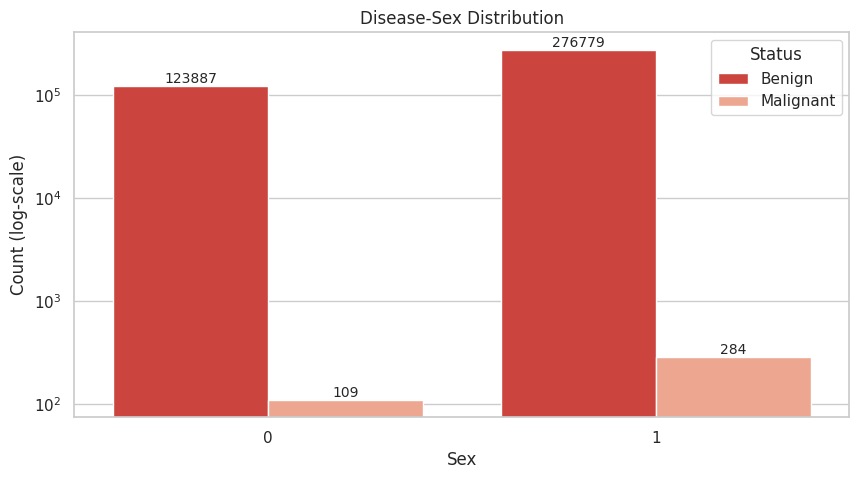

In [ ]:
# very large/very small values rep. using log-scale
# resource: https://stackoverflow.com/questions/57722200/how-to-represent-very-large-and-a-very-small-values-in-a-plot
sns.set_theme(style='whitegrid')

fig = plt.figure(figsize=(10,5))
ax = sns.barplot(target_sex_count, x='sex', y='count', hue='status', palette='Reds_r', errorbar=None)
ax.set_yscale("log")
_ = ax.set(title='Disease-Sex Distribution',xlabel="Sex", ylabel="Count (log-scale)")

for container in ax.containers:
    ax.bar_label(container, fontsize=10)

ax.legend(title='Status', loc='upper right', labels=['Benign', 'Malignant'])
plt.show()

### 4.2 Age Range Incidence Rates
Note: The Skin Cancer Age Range is an approximation.

Citation/URL: https://www.gentlecure.com/skin-cancer-age-range/#:~:text=Although%20patients%20older%20than%2075,by%20the%20age%20of%2070.

In [ ]:
def checkAgeRange(age):
    age = int(age)
    beg_digit = age - 5
    last_digit = age - 1
    return (f"{beg_digit}-{last_digit}")

In [ ]:
# Evidence — Based on this data there is weak evidence suggesting adults past 50 y/o
# are more likely to develop skin cancer.

target_age_approx = train_metadata.groupby(['target', 'age_approx']).size().to_frame('size').reset_index()
total = target_age_approx['size'].sum()
target_age_approx['percent'] = target_age_approx['size'] / total
target_age_approx['age_range'] = target_age_approx['age_approx'].apply(checkAgeRange)

In [ ]:
# target_age_approx

In [ ]:
benign = target_age_approx.loc[target_age_approx['target']==0]
malignant = target_age_approx.loc[target_age_approx['target']==1]

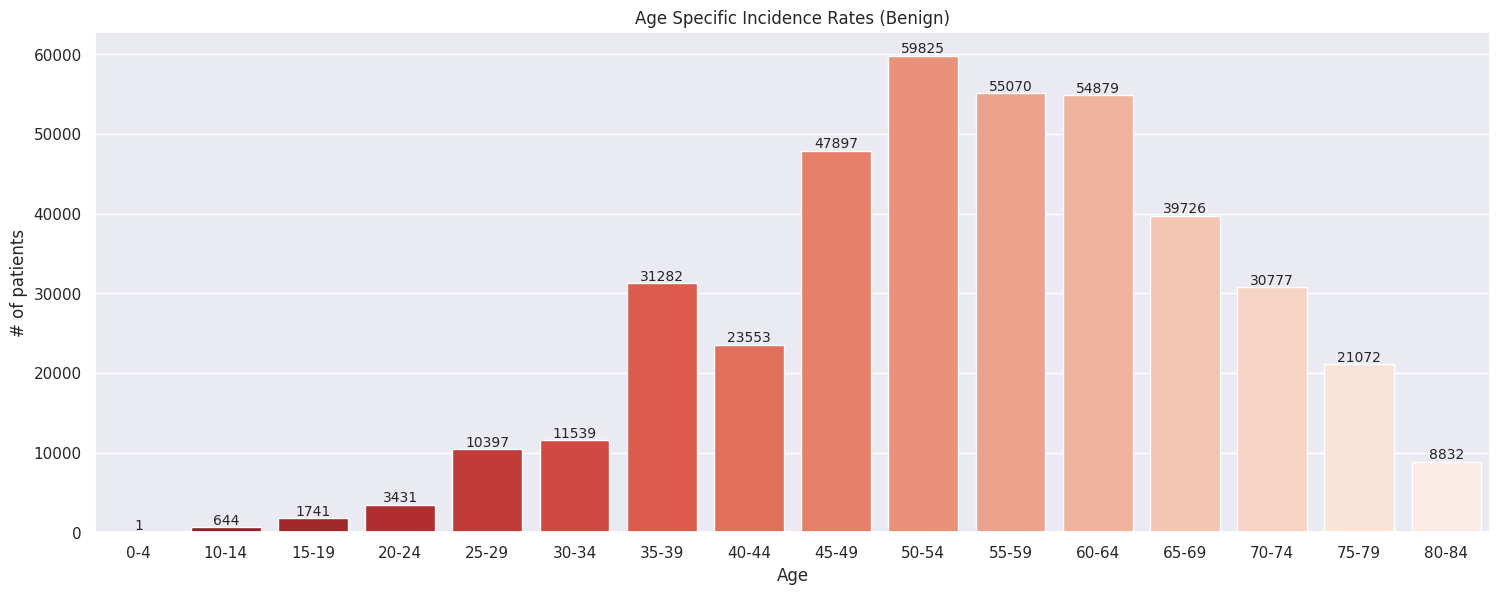

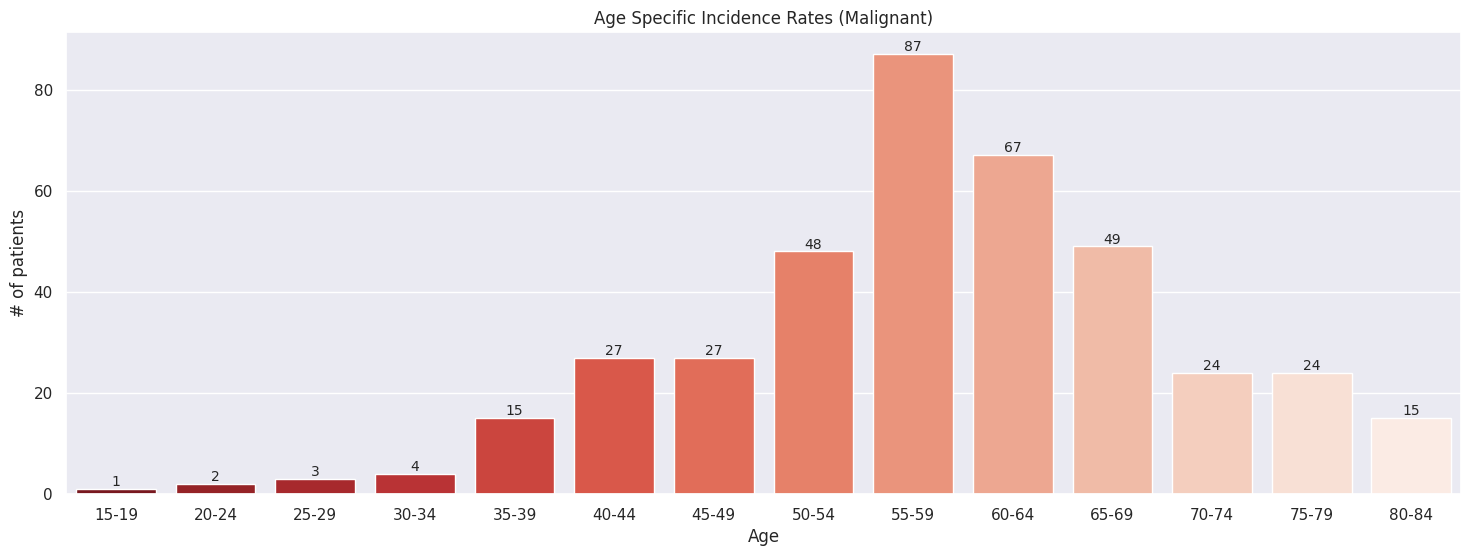

In [ ]:
sns.set_theme(style='darkgrid')

# Benign
fig = plt.figure(figsize=(18, 6.5))
ax = sns.barplot(benign, x='age_range', y='size', palette='Reds_r', errorbar='ci')
_ = ax.set(title="Age Specific Incidence Rates (Benign)", xlabel='Age', ylabel='# of patients')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

# Malignant
fig = plt.figure(figsize=(18, 6))
ax = sns.barplot(malignant, x='age_range', y='size', palette='Reds_r', errorbar='ci')
_ = ax.set(title="Age Specific Incidence Rates (Malignant)", xlabel='Age', ylabel='# of patients')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

plt.show()

Notes: Look at age range 35-39. consider if the following drop in 40-44 is significant. let us consider how this service would benefit patients in preventive care and triage those who are in at risk. The above barplot showcases the confidence intervals for

In [ ]:
train_metadata['age_range_under50'] = None
train_metadata.loc[train_metadata['age_approx']<50, 'age_range_under50'] = True
train_metadata.loc[train_metadata['age_approx']>50, 'age_range_under50'] = False
train_metadata['age_range_under50'].value_counts()

,count
age_range_under50,
False,270495
True,82640


In [ ]:
age_range_count = train_metadata.groupby(['target', 'age_range_under50']).size()

In [ ]:
age_range_count

target  age_range_under50
0       False                270181
        True                  82588
1       False                   314
        True                     52
dtype: int64

### 4.4 Disease location distribution (Pending)



In [ ]:
# benign
fig = plt.figure(figsize=(18,6))
ax = sns.barplot


<Figure size 1800x600 with 0 Axes>

In [ ]:
train_metadata['tbp_lv_location'].value_counts().sum()

401059

In [ ]:
train_metadata['anatom_site_general'].value_counts().sum()

395303

In [ ]:
train_metadata.tbp_lv_location.unique()

array(['Right Leg - Upper', 'Head & Neck', 'Torso Back Top Third',
       'Torso Front Top Half', 'Right Arm - Upper', 'Left Leg - Upper',
       'Torso Front Bottom Half', 'Left Arm - Upper', 'Right Leg',
       'Torso Back Middle Third', 'Right Arm - Lower',
       'Right Leg - Lower', 'Left Leg - Lower', 'Left Arm - Lower',
       'Unknown', 'Left Leg', 'Torso Back Bottom Third', 'Left Arm',
       'Right Arm', 'Torso Front', 'Torso Back'], dtype=object)

In [ ]:
train_metadata.anatom_site_general.unique()

array(['lower extremity', 'head/neck', 'posterior torso',
       'anterior torso', 'upper extremity', nan], dtype=object)

### 4.5 Lesion Size & Target (Pending)

In [ ]:
train_metadata.clin_size_long_diam_mm.mean()

3.9308271850276397

In [ ]:
train_metadata.tbp_lv_areaMM2.min()

0.431600675548883

## 5. Image Processing, Visualization, and Augmentations
- Create PyTorch dataset object
- Load and normalize the images and consider applying transformations (i.e., horizontal, veritical, blur, etc)
- Normalization helps get data within a range and reduces the skewness which helps learn faster and better
- Dataloader (pending)

In [ ]:
class SkinCancerDataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None):
    """
    Arguments:
        csv_file (string): Path to the csv with annotations (aka annotations file)
        img_dir (string): Directory with all images.
        transform (callable, optionable): Optional transform to be applied on a sample
    """
    self.metadata = pd.read_csv(csv_file,
                                dtype={'iddx_5': str, 'mel_mitotic_index': str})
    self.isic_ids = self.metadata.isic_id
    self.targets = self.metadata.target
    self.hdf5_file = img_dir
    self.transform = transform

    # Open the hdf5 file during init
    self.hdf5_data = h5py.File(self.hdf5_file,'r+')

  # The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.metadata)

  # Defining the method to get an item from the dataset
  def __getitem__(self, idx):
    img_id = self.isic_ids[idx]
    img_label = self.targets[idx]

    # Access the image data contained in hdf5 file, with the isic_id as key
    img_binary = self.hdf5_data[img_id][()]
    img = Image.open(BytesIO(img_binary)).convert("RGB")

    # Apply transformation (optional) on a sample
    if self.transform:
      img = self.transform(img)

    return img, img_label

  def __del__(self):
    self.hdf5_data.close()

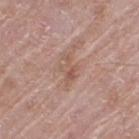

In [ ]:
skin_dataset = SkinCancerDataset(csv_file=train_metadata_path,
                                 img_dir=train_img_path)

# Quick image test
skin_dataset.__getitem__(0)[0]

**Malignant vs Benign Images**

Let's have a quick look at images between both classes.

In [ ]:
def display_images(dataset, n: int = 5, target = None, seed: int = None):
    if n > 5:
        n = 5
        print("For display purposes, n shouldn't be larger than 5.")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    if target is not None:
      random_samples_idx = random.sample(target, k=n)

    fig = plt.figure(figsize=(6.4, 4.8))

    for i, idx in enumerate(random_samples_idx):
        image, label = dataset[idx]

        ax = plt.subplot(1, n, i + 1)
        ax.set_title(f"Sample {idx} \n {image.size}", fontsize=10)
        ax.text(0.5, -0.1, f"Class: {label}", ha='center', va='top', transform=ax.transAxes, fontsize=10)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()


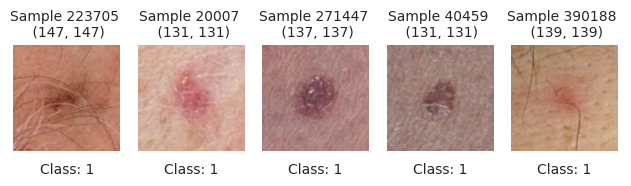

In [ ]:
malignant = list(skin_dataset.metadata[skin_dataset.metadata['target'] == 1].index)
display_images(skin_dataset, n = 5, target=malignant)

Torchvision.transforms

In [ ]:
# Function to display images after transformations
def show_transform(image, title="Default"):
  # plt.figure(figsize=(10,5))
  plt.figure(figsize=(6.4, 4.8))
  plt.title(title, fontsize=12)

  # Unnormalize + revert back from Torch to Numpy
  image = image / 2 + 0.5
  npimg = image.numpy()
  npimg = np.clip(npimg, 0., 1.)
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [ ]:
image, label = skin_dataset[1]
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.CenterCrop((100,100)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ])
img = transform(image)

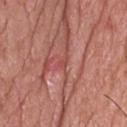

In [ ]:
image

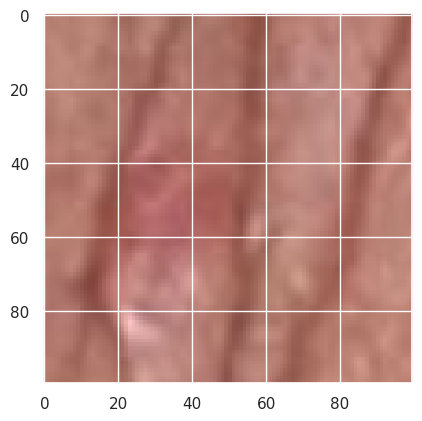

In [ ]:
plt.figure()
img = img / 2 + 0.5
npimg = img.numpy()
npimg = np.clip(npimg, 0., 1.)
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

###1. Crop ✂️

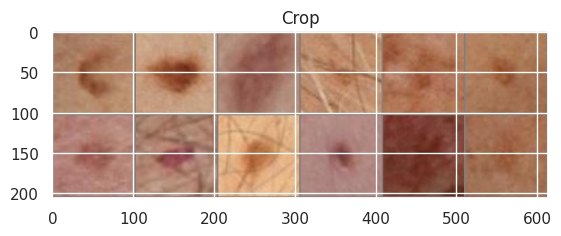

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224,244)),
                                transforms.CenterCrop((100,100)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ])

pytorch_dataset = SkinCancerDataset(csv_file=train_metadata_path,
                                    img_dir=train_img_path,
                                    transform=transform)

pytorch_dataloader = DataLoader(pytorch_dataset, batch_size=12, shuffle=True)

images, labels = next(iter(pytorch_dataloader))

show_transform(torchvision.utils.make_grid(images, nrow=6), title="Crop")

###2. ColorJitter 🎨
Randomly

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ColorJitter(brightness=1.9),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

                                ])

pytorch_dataset = SkinCancerDataset(csv_file=train_metadata_path,
                                    img_dir=train_img_path,
                                    transform=transform)

pytorch_dataloader = DataLoader(pytorch_dataset, batch_size=12, shuffle=True)

images, labels = next(iter(pytorch_dataloader))

show_transform(torchvision.utils.make_grid(images, nrow=6), title="ColorJitter")